In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib, os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [6]:
df = pd.read_csv("C:\\Users\\Yash\\OneDrive\\Desktop\\Datasets and completed analysis\\Datasets\\Loan Classification dataset\\loan.csv")
print("Shape:", df.shape)
print(df.head(3))

Shape: (39717, 111)
        id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   

  int_rate  installment grade sub_grade  ... num_tl_90g_dpd_24m  \
0   10.65%       162.87     B        B2  ...                NaN   
1   15.27%        59.83     C        C4  ...                NaN   
2   15.96%        84.33     C        C5  ...                NaN   

  num_tl_op_past_12m pct_tl_nvr_dlq  percent_bc_gt_75 pub_rec_bankruptcies  \
0                NaN            NaN               NaN                  0.0   
1                NaN            NaN               NaN                  0.0   
2                NaN            NaN               NaN                  0.0   

  tax_liens tot_hi_cred_lim total_bal_ex_mort total_bc_limit  \
0       0.0          

C:\Users\Yash\AppData\Local\Temp\ipykernel_21840\3735051402.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:\\Users\\Yash\\OneDrive\\Desktop\\Datasets and completed analysis\\Datasets\\Loan Classification dataset\\loan.csv")


In [10]:
target_candidates = ['loan_status','Loan_Status','LoanStatus','loanstatus','status','loan_status ']
target = next((c for c in target_candidates if c in df.columns), df.columns[-1])

In [12]:
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip()
if 'Dependents' in df.columns:
    df['Dependents'] = df['Dependents'].replace({'3+':'3'})
    df['Dependents'] = pd.to_numeric(df['Dependents'], errors='coerce')

In [14]:
if df[target].dtype == object:
    df[target] = df[target].map({'Y':1,'N':0}).fillna(df[target])
if df[target].dtype == object:
    df[target], class_names = pd.factorize(df[target], sort=True)
    print("Class names:", list(class_names))
else:
    class_names = None

Class names: ['Charged Off', 'Current', 'Fully Paid']


In [18]:
threshold = int(0.7 * len(df))
drop_sparse = [c for c in df.columns if df[c].isnull().sum() > threshold]
id_like = [c for c in df.columns if any(tok in c.lower() for tok in ['id','url','member','addr','desc','title','emp_title'])]
drop_cols = list(set(drop_sparse + id_like) - {target})
df = df.drop(columns=drop_cols)

In [20]:
y = df[target]
X = df.drop(columns=[target])

In [24]:
cat_cols = X.select_dtypes(include='object').columns.tolist()
low_card = [c for c in cat_cols if X[c].nunique() <= 10]
high_card = [c for c in cat_cols if c not in low_card]

In [26]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    if X[c].isnull().any():
        X[c] = X[c].fillna(X[c].median())
for c in low_card:
    X[c] = X[c].fillna(X[c].mode()[0])

In [28]:
for c in high_card:
    freq = X[c].value_counts(normalize=True)
    X[c] = X[c].map(freq).fillna(0)

In [30]:
X = pd.get_dummies(X, columns=low_card, drop_first=True)

In [32]:
X = X.loc[:, (X.isnull().mean() < 0.5)]
X = X.loc[:, (X.nunique() > 1)]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (31773, 49) Test shape: (7944, 49)


In [36]:
clf = DecisionTreeClassifier(random_state=42, max_depth=6)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Baseline accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Baseline accuracy: 0.9857754279959718
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95      1125
           1       1.00      1.00      1.00       228
           2       0.98      1.00      0.99      6591

    accuracy                           0.99      7944
   macro avg       0.99      0.97      0.98      7944
weighted avg       0.99      0.99      0.99      7944

Confusion matrix:
 [[1012    0  113]
 [   0  228    0]
 [   0    0 6591]]


In [38]:
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 20 features:\n", importances.head(20))

Top 20 features:
 recoveries                             0.634578
out_prncp_inv                          0.199427
total_rec_prncp                        0.080822
funded_amnt                            0.072528
last_pymnt_amnt                        0.007449
last_credit_pull_d                     0.003138
loan_amnt                              0.002058
home_ownership_OTHER                   0.000000
home_ownership_OWN                     0.000000
next_pymnt_d_Jun-16                    0.000000
total_rec_late_fee                     0.000000
verification_status_Verified           0.000000
verification_status_Source Verified    0.000000
collection_recovery_fee                0.000000
last_pymnt_d                           0.000000
home_ownership_RENT                    0.000000
pub_rec_bankruptcies                   0.000000
home_ownership_NONE                    0.000000
term_60 months                         0.000000
grade_B                                0.000000
dtype: float64


In [40]:
param_grid = {'max_depth':[4,6,8,10,None], 'min_samples_leaf':[1,5,10], 'criterion':['gini','entropy']}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='f1_weighted', n_jobs=1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)

Best params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5}


In [41]:
best = gs.best_estimator_
y_pred_best = best.predict(X_test)
print("Tuned accuracy:", accuracy_score(y_test, y_pred_best))
print("Tuned classification report:\n", classification_report(y_test, y_pred_best, zero_division=0))

Tuned accuracy: 0.9948388721047331
Tuned classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1125
           1       1.00      1.00      1.00       228
           2       1.00      1.00      1.00      6591

    accuracy                           0.99      7944
   macro avg       0.99      0.99      0.99      7944
weighted avg       0.99      0.99      0.99      7944



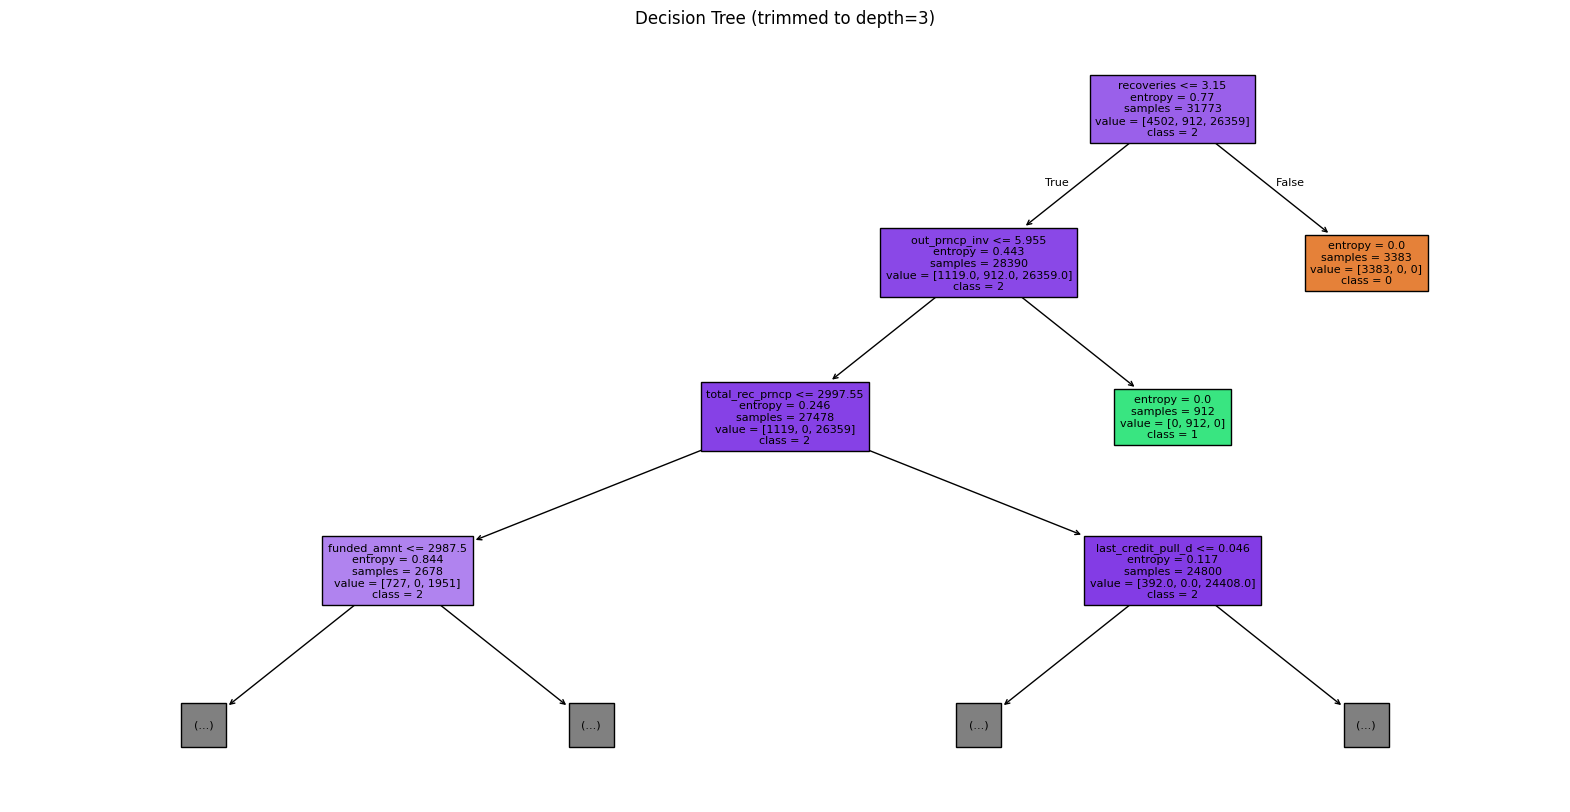

In [60]:
plt.figure(figsize=(20, 10))
plot_tree(best,feature_names=X.columns,class_names=[str(c) for c in sorted(pd.unique(y))],max_depth=3,filled=True,fontsize=8)
plt.title("Decision Tree (trimmed to depth=3)")
plt.show() 